# Build a decision tree

In [2]:
# Import the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [4]:
df_original=pd.read_csv(r'C:\Users\user\Desktop\Course 6\churn_df.csv')

In [6]:
df_original['Exited'].value_counts(normalize= True)*100

0    79.63
1    20.37
Name: Exited, dtype: float64

The class of our target variable is split roughly 80/20. In other words, ~20% of the people in this dataset churned. This is an unbalanced dataset, but it's not extreme. We will preserve this ratio when we model.

## Select an evaluation metric  

The data contains 10,000 observations, and the class distribution is approximately 80/20. 

Since we have some imbalance in our target classes, we know that if we measure model performance by accuracy alone, the model could predict 0 (no churn) 100% of the time and have an accuracy of ~80%. An accuracy of 80% might seem pretty good, but we know in this case it would be meaningless, because our model would fail to identify anybody who churned. Therefore, accuracy is not the best metric to use to evaluate our model's performance.  

To determine which evaluation metric might be best, consider how our model might be wrong. There are two possibilities for bad predictions: 
  
  - **False positives:** When the model predicts a customer **will** churn when in fact they won't
  - **False negatives:** When the model predicts a customer will **not** churn when in fact they will     


In [8]:
# Calculate average balance of customers who churned
avg_churned_bal= df_original[df_original['Exited']==1]['Balance'].mean()
avg_churned_bal

91108.53933726063

This shows that the customers who churned each took with them €91,108.54, on average. That's a lot of money! This represents the average cost of the model predicting a false negative. 

What's the cost of predicting a false positive? Well, it's the cost of whatever the incentive might be to convince someone to stay with the bank when they were going to stay regardless of whether or not they were incentived. We don't have a number for this, and even if it's probably less than €91,108.54, it still could be thousands of Euros per customer in lost revenue, depending on the details of the incentive. 

### Split the data

In [11]:
# Define the y (target) variable
y= df_original['Exited']

# Define the X (predictor) variables
X= df_original.drop(['Exited'], axis=1)

# Split into train and test sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.25, stratify= y, random_state=42)

## Baseline model

We'll first train a baseline model, just to get a sense of how predictive the data is and to give us scores that we can reference later. This will also show the process of instantiating and fitting the model, and then using it to make predictions. 

In [13]:
# Instantiate the model
decision_tree= DecisionTreeClassifier(random_state= 0)

# Fit the model to training data
decision_tree.fit(X_train, y_train)

# Make predictions on test data
dt_pred= decision_tree.predict(X_test)

In [14]:
# Generate performance metrics
print("Accuracy:", "%.3f" % accuracy_score(y_test, dt_pred))
print("Precision:", "%.3f" % precision_score(y_test, dt_pred))
print("Recall:", "%.3f" % recall_score(y_test, dt_pred))
print("F1 Score:", "%.3f" % f1_score(y_test, dt_pred))

Accuracy: 0.802
Precision: 0.515
Recall: 0.511
F1 Score: 0.513


A comparison of F1 scores reveals that the decision tree is an improvement to the Naive Bayes model we built earlier. For reference, here are the scores of both models:

| Model | F1 | Recall | Precision | Accuracy |
| :- | :-: | :-: | :-: | :-: |
| Decision Tree | 0.513 | 0.511 | 0.515 | 0.802 |
| Naive Bayes |  0.389 | 0.303 | 0.544 | 0.806 |





### Confusion matrix for baseline model

In [18]:
def conf_matrix_plot(model, x_data, y_data):
    model_pred= model.predict(x_data)
    cm= confusion_matrix(y_data, model_pred, labels=model.classes_)
    disp= ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels= model.classes_)
    disp.plot()
    plt.show()

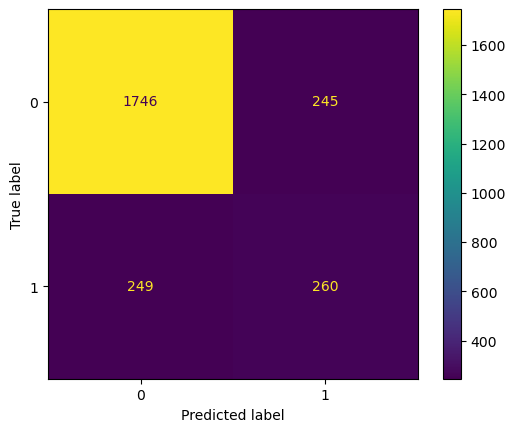

In [19]:
conf_matrix_plot(decision_tree, X_test, y_test)

Notice from this confusion matrix that the model correctly predicts many true negatives. Of course, this is to be expected, given that the dataset is imbalanced in favor of negatives. When the model makes an error, it appears slightly more likely to predict a false positive than a false negative, but it's generally balanced. This is reflected in the precision and recall scores both being very close to each other. 

### Plotting the tree

Next, let's examine the splits of the tree. We'll do this by using the `plot_tree()` function that we imported. We pass to it our fit model as well as some additional parameters. Note that if we did not set `max_depth=2`, the function would return a plot of the entire tree, all the way down to the leaf nodes. This is intractable and unnecessary. We're most interested in the splits nearest the root, because these tell us the most predictive features.

`class_names` displays what the majority class of each node is, and `filled` colors the nodes according to their majority class. 

Note that this plot represents how the tree grew from the _training data_. To make its predictions on the test data, the tree would simply pass each customer in the test data through its splits, from the root node all the way down to a leaf node.

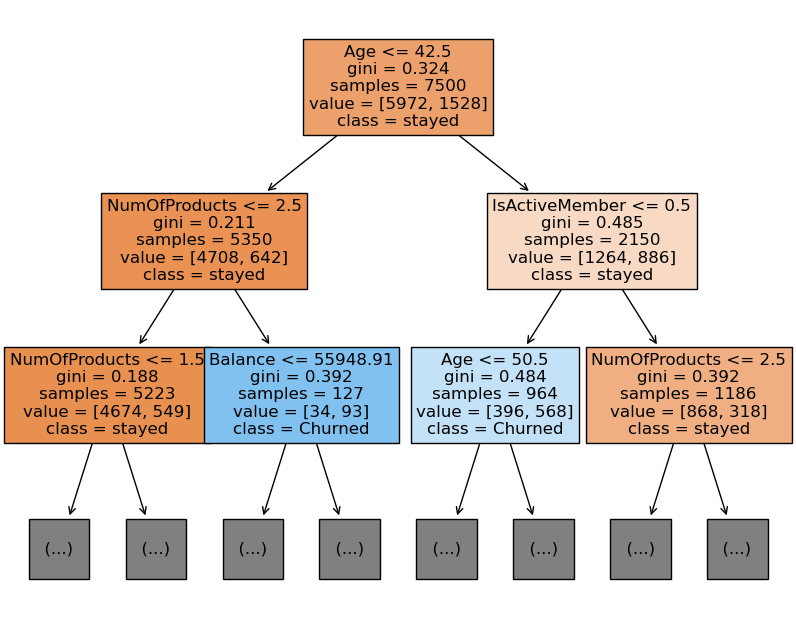

In [29]:
plt.figure(figsize= (10,8))
plot_tree(decision_tree,max_depth= 2, fontsize=12, feature_names= X.columns,
         class_names= {0:'stayed', 1:'Churned'}, filled= True)
plt.show()

### Interpreting the above plot
The first line of information in each node is the feature and split point that the model identified as being most predictive. In other words, this is the question that is being asked at that split. For our root node, the question was: _Is the customer less than or equal to 42.5 years old?_

At each node, if the answer to the question it asks is "yes," the sample would move to the child node on the left. If the answer is "no," the sample would go to the child node on the right.

`gini` refers to the node's _Gini impurity_. This is a way of measuring how "pure" a node is. The value can range from 0 to 0.5. A Gini score of 0 means there is no impurity&mdash;the node is a leaf, and all of its samples are of a single class. A score of 0.5 means the classes are all equally represented in that node.

`samples` is simply how many samples are in that node, and `value` indicates how many of each class are in the node. Returning to the root node, we have `value = [5972, 1528]`. Notice that these numbers sum to 7,500, which is the number of samples in the node. This tells us that 5,972 customers in this node stayed (y=0) and 1,528 customers churned (y=1).

Lastly, we have `class`. This tells us the majority class of the samples in each node.

### Quick Insight

This plot tells us that, if we could only do a single split on a single variable, the one that would most help us predict whether a customer will churn is their age.

If we look at the nodes at depth one, we notice that the number of products and whether or not the customer is an active member also are both strong predictors.

This is a good indication that it might be worthwhile to return to EDA and examine these features more closely. 

Finally, it's worth noting that there is no single question that can be asked&mdash;for any feature&mdash;that would cause a majority of samples in one of the child nodes to be of class "churned." The tree must get to depth two (i.e., two questions must be asked) before this happens.

# Tune and Validate a decision tree

In [30]:
# Import #GridSearchCV
from sklearn.model_selection import GridSearchCV

In [46]:
# Assign a dictionary of hyperparameters to search over
tree_para = {'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50],
             'min_samples_leaf': [2, 5, 10, 20, 50]}

In [47]:
tree_para

{'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50],
 'min_samples_leaf': [2, 5, 10, 20, 50]}

* Create a dictionary of scoring metrics to capture. These metrics can be selected from scikit-learn's built-in options or custom-defined. For this exercise, we'll capture accuracy, precision, recall, and F1 score so we can examine all of them. The metrics are entered as strings.

In [50]:
# Assign a dictionary of scoring metrics to capture
scoring= {'accuracy', 'precision', 'recall', 'f1'}
scoring

{'accuracy', 'f1', 'precision', 'recall'}

In [51]:
# Instantiate the classifier
tuned_decision_tree= DecisionTreeClassifier(random_state=42)

* Instantiate the `GridSearchCV` object. Pass as arguments:
  - The classifier (`tuned_decision_tree`)
  - The dictionary of hyperparameters to search over (`tree_para`)
  - The dictionary of scoring metrics (`scoring`)
  - The number of cross-validation folds we want (`cv=5`)
  - The scoring metric we want GridSearch to use when it selects the "best" model (`refit='f1'`*)


* Fit the data (`X_train`, `y_train`) to the `GridSearchCV` object (`clf`)

In [52]:
# Instantiate the GridSearch
clf = GridSearchCV(tuned_decision_tree, 
                   tree_para, 
                   scoring = scoring, 
                   cv=5, 
                   refit="f1")

# Fit the model
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50],
                         'min_samples_leaf': [2, 5, 10, 20, 50]},
             refit='f1', scoring={'recall', 'f1', 'precision', 'accuracy'})

In [53]:
clf.best_estimator_

DecisionTreeClassifier(max_depth=7, min_samples_leaf=20, random_state=42)

The `best_score_` attribute returns the best average F1 score across the different folds among all the combinations of hyperparameters. Note that if we had set `refit='recall'` when we instantiated our `GridSearchCV` object earlier, then calling `best_score_` would return the best recall score, and the best parameters might not be the same as what they are in the above cell, because the model would be selected based on a different metric.

In [54]:
print('Best avg validation score:' '%.3f' %clf.best_score_)

Best avg validation score:0.561


Although the `F1 score` of `0.561` is significantly better than the baseline model's `F1 score` of `0.513`, it's not a fair comparison, because the baseline model was scored on the test data and the tuned model was scored against validation folds that came from the training data.